In [13]:
import os

# 오직 중요한 로깅만 활성화하기 (선택적)
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [15]:
# 설치된 라이브러리 확인
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    %pip install pycaret
    what_is_installed()


System:
    python: 3.9.19 (main, May  6 2024, 19:43:03)  [GCC 11.2.0]
executable: /home/nhnacademy/anaconda3/envs/smoothing_ml/bin/python
   machine: Linux-6.5.0-28-generic-x86_64-with-glibc2.35

PyCaret required dependencies:
                 pip: 24.0
          setuptools: 69.5.1
             pycaret: 3.3.2
             IPython: 8.12.0
          ipywidgets: 8.1.2
                tqdm: 4.66.4
               numpy: 1.26.4
              pandas: 2.1.4
              jinja2: 3.1.4
               scipy: 1.11.4
              joblib: 1.3.2
             sklearn: 1.4.2
                pyod: 1.1.3
            imblearn: 0.12.2
   category_encoders: 2.6.3
            lightgbm: 4.3.0
               numba: 0.59.1
            requests: 2.31.0
          matplotlib: 3.7.5
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.22.0
    plotly-resampler: Not installed
             kaleido: 0.2.1
           schemdraw: 0.15
         statsmodels: 0.14.2
              sktime: 0.26.0


In [16]:
# 노트북을 위한 global fugure 설정
global_fig_settings = {
    # 'renderer': 'notebook',
    "renderer": "png",  # 'notebook' 으로 설정시 interactive 시각화 가능
    "width": 1000,
    "height": 600,
}

In [17]:
# 필요한 모듈 import
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment 

In [5]:
device_power_sensor_data = pd.read_csv('all_data/all_final_df/class_a_device_power_sensor.csv')
environmental_sensor_data = pd.read_csv('all_data/all_final_df/class_a_environmental_sensor.csv')
device_power_sensor_data['time'] = pd.to_datetime(device_power_sensor_data['time'])
environmental_sensor_data['time'] = pd.to_datetime(environmental_sensor_data['time'])

In [18]:
# 두 데이터셋 병합
data = pd.merge(
    environmental_sensor_data[['time', 'average_humidity(%)', 'average_co2(ppm)', 'average_illumination(lux)']],
    device_power_sensor_data[['time', 'socket_power(Wh)']],
    on='time',
    how='inner'
)

print(data.head())

                 time  average_humidity(%)  average_co2(ppm)  \
0 2024-04-15 01:00:00             3.889900          6.452591   
1 2024-04-15 02:00:00             3.910842          6.417467   
2 2024-04-15 03:00:00             3.902881          6.383676   
3 2024-04-15 04:00:00             3.898512          6.366752   
4 2024-04-15 05:00:00             3.900355          6.347820   

   average_illumination(lux)  socket_power(Wh)  
0                   4.247366          7.111104  
1                   2.184477          7.016610  
2                   0.000000          7.014365  
3                   0.000000          7.021530  
4                   0.000000          7.015712  


In [19]:
target = 'socket_power(Wh)'

In [20]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   time                       600 non-null    datetime64[ns]
 1   average_humidity(%)        600 non-null    float64       
 2   average_co2(ppm)           600 non-null    float64       
 3   average_illumination(lux)  600 non-null    float64       
 4   socket_power(Wh)           600 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 23.6 KB
None


In [21]:
# EDA 실험 만들기
eda = TSForecastingExperiment()

In [22]:
# Setup 함수에서 데이터 전처리에 대한 설정을 지정합니다.
_ = eda.setup(
    data=data,  # 데이터프레임 전달
    target=target,  # 예측 컬럼
    index="time",  # Time 컬럼
    # Forecast Horizon: 예측할 미래 기간을 입력합니다.
    fh=48,
    # 'drift', 'linear', 'nearest', 'mean', 'median', 'backfill', 'bfill', 'pad', 'ffill', 'random'
    numeric_imputation_target="drift",
    # 'drift', 'linear', 'nearest', 'mean', 'median', 'backfill', 'bfill', 'pad', 'ffill', 'random'
    numeric_imputation_exogenous="drift",
    fig_kwargs=global_fig_settings,  # 플롯에 대한 기본 설정을 지정합니다
    session_id=42,
)

,Description,Value
0,session_id,42
1,Target,socket_power(Wh)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(600, 4)"
5,Transformed data shape,"(600, 4)"
6,Transformed train set shape,"(552, 4)"
7,Transformed test set shape,"(48, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [25]:
# 시계열 데이터 시각화 with 세부설정
eda.plot_model(
    plot="ts",
    fig_kwargs={
        "height": 1200,
        # resampler_kwargs를 사용하여, plotly-resampler 객체의 생성자를 구성할 수 있습니다.
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            # show_dash kwargs는 show_dash (render) 메서드의 kwargs를 보류합니다.
            "show_dash": {"mode": "inline", "port": 8055},
        },
    },
    display_format='plotly-dash',
    # display_format="plotly-widget",
)

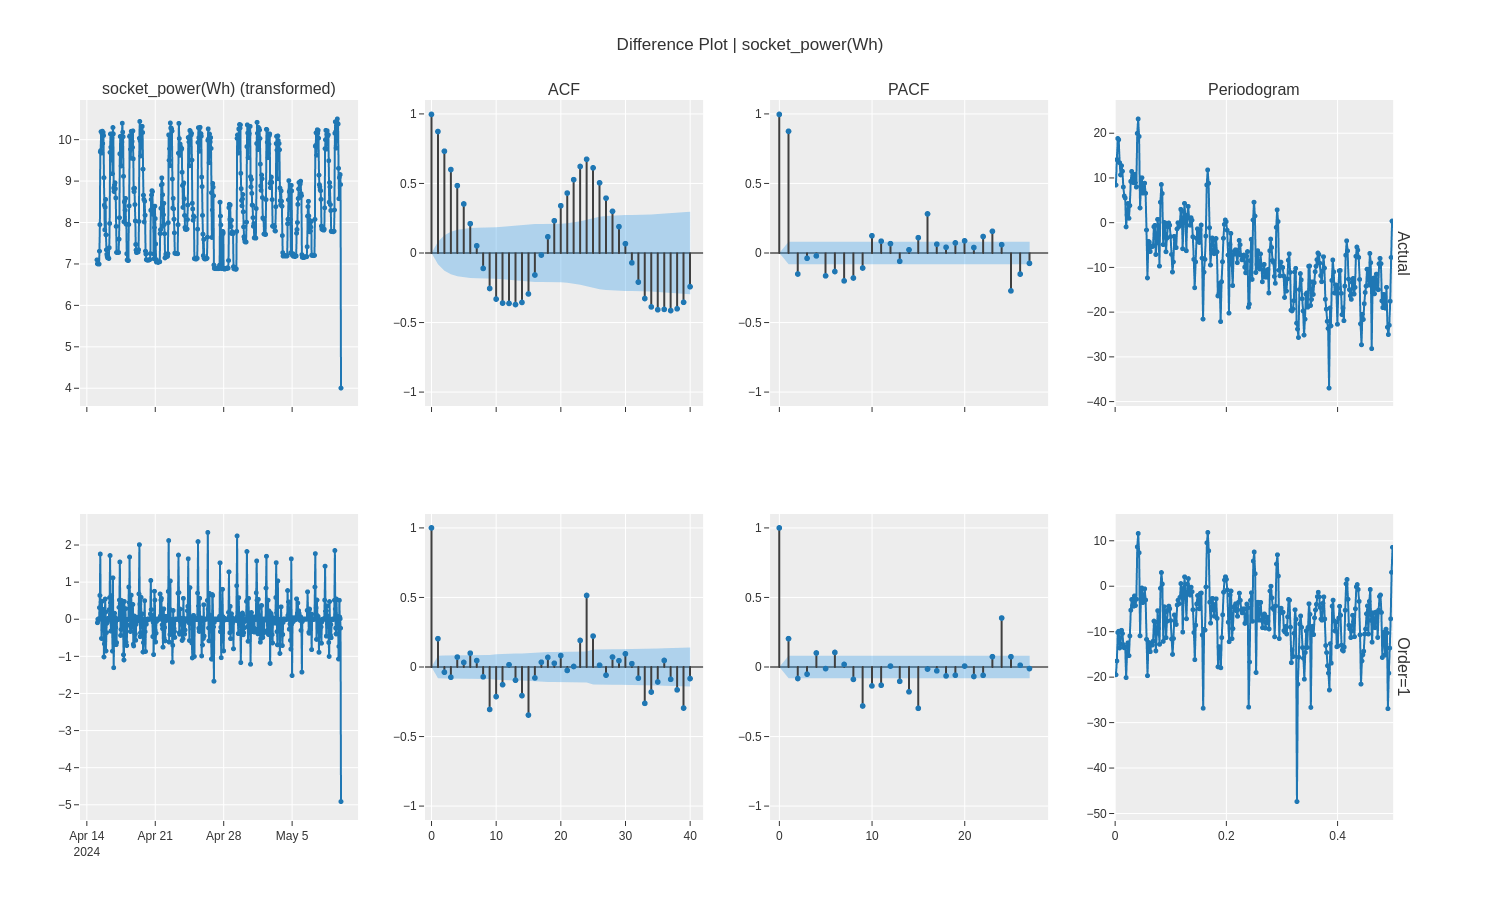

In [26]:
# 기본적으로 원본 데이터를 첫 번째 차분(order d = 1)과 함께 그래프로 그립니다.
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "width": 1500,
        "height": 900,
        # plotly-widget을 사용할 때는 show_dash kwargs를 전달할 필요가 없습니다.
        "resampler_kwargs": {"default_n_shown_samples": 1500},
    },
    data_kwargs={"acf": True, "pacf": True, "periodogram": True},
    # display_format='plotly-dash', # interactive 시각화 출력을 원한다면 주석을 해제 합니다.
    # display_format='plotly-widget', # interactive 시각화 출력을 원한다면 주석을 해제 합니다.
)

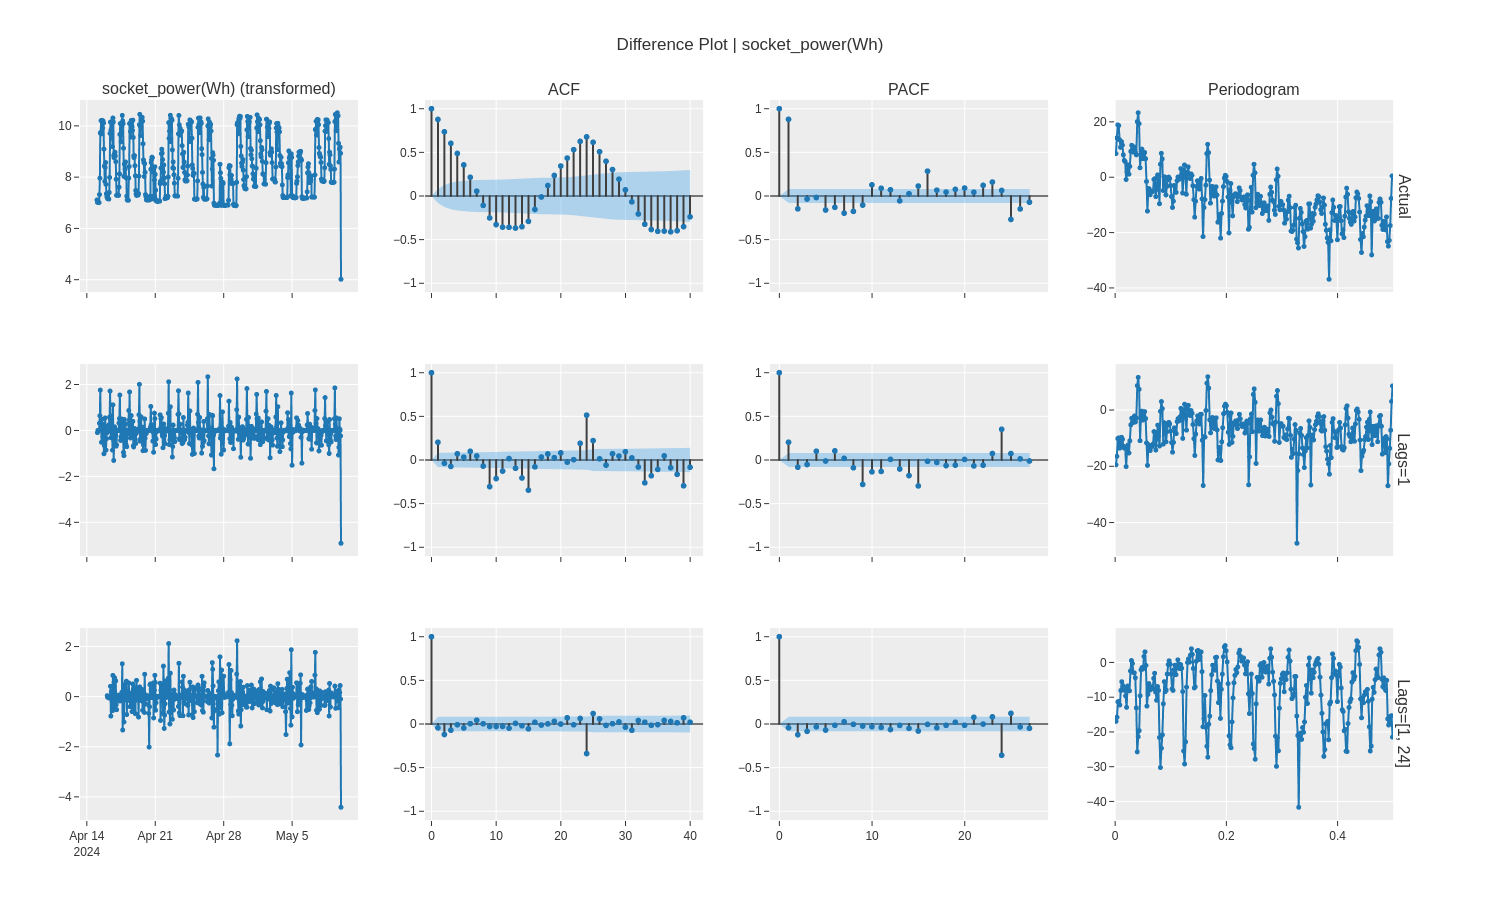

In [27]:
# 차분에 대한 시각화
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "width": 1500,
        "height": 900,
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            "show_dash": {"mode": "inline", "port": 8056},
        },
    },
    data_kwargs={
        "lags_list": [1, [1, 24]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    # display_format='plotly-dash',    # interactive 시각화 출력을 원한다면 주석을 해제 합니다.
    # display_format="plotly-widget",  # interactive 시각화 출력을 원한다면 주석을 해제 합니다.
)

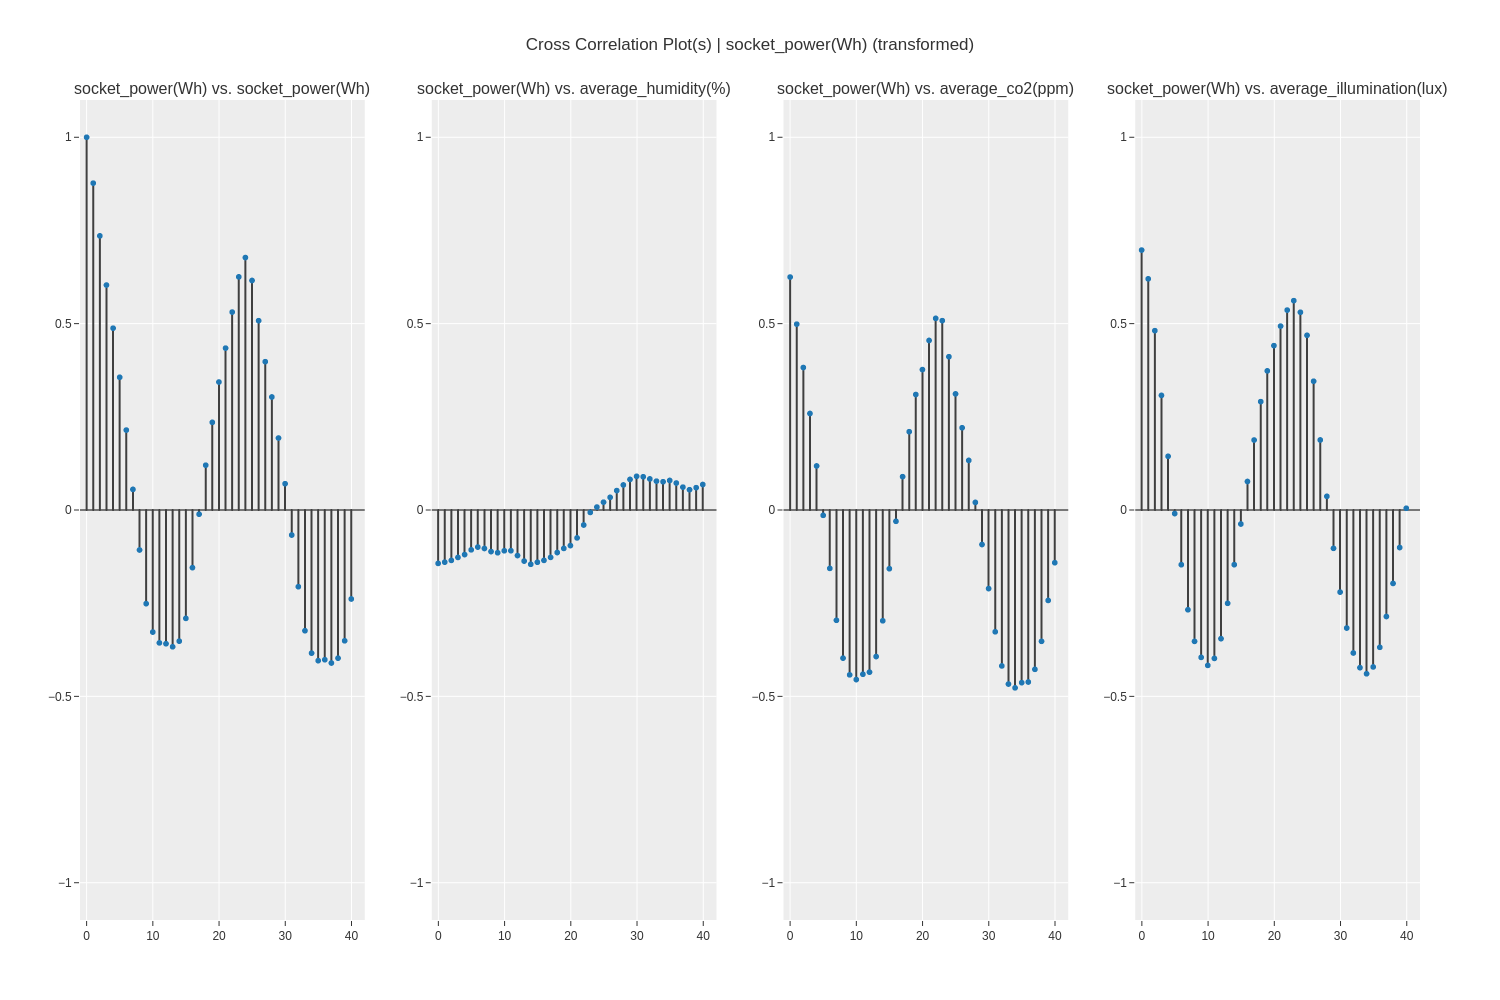

In [28]:
# Cross Correlation Plot 시각화
eda.plot_model(plot="ccf", fig_kwargs={"height": 1000, "width": 1500})

In [46]:
# 시계열 실험(Experiment) 객체를 생성합니다.
exp_uni = TSForecastingExperiment()

# 설정 값 지정
exp_uni.setup(
    data=data[target],
    fh=110,  # (예측 time-step) forecast horizon 설정
    numeric_imputation_target="linear",
    numeric_imputation_exogenous="linear",
    fig_kwargs=global_fig_settings,
    session_id=42,
)

,Description,Value
0,session_id,42
1,Target,socket_power(Wh)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(600, 1)"
5,Transformed data shape,"(600, 1)"
6,Transformed train set shape,"(490, 1)"
7,Transformed test set shape,"(110, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [47]:
# 'arima' 모델을 생성합니다.
model = exp_uni.create_model(
    "arima",  # ARIMA, SARIMA, SARIMAX 등을 커버. 모두 동일하게 arima 로 지정
    order=(0, 1, 0),  # (p, d, q)
    seasonal_order=(0, 1, 0, 24),  # (p, d, q, s)
)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,159.0000,1.7136,1.4808,0.9673,1.2249,0.1158,0.1128,-0.0924
1,269.0000,1.4083,1.4462,0.7701,1.1960,0.1011,0.0922,0.0952
2,379.0000,3.4560,2.7301,1.8638,2.3011,0.2325,0.1966,-3.9647
Mean,nan,2.1926,1.8857,1.2004,1.5740,0.1498,0.1339,-1.3206
SD,nan,0.9020,0.5972,0.4760,0.5143,0.0588,0.0451,1.8712


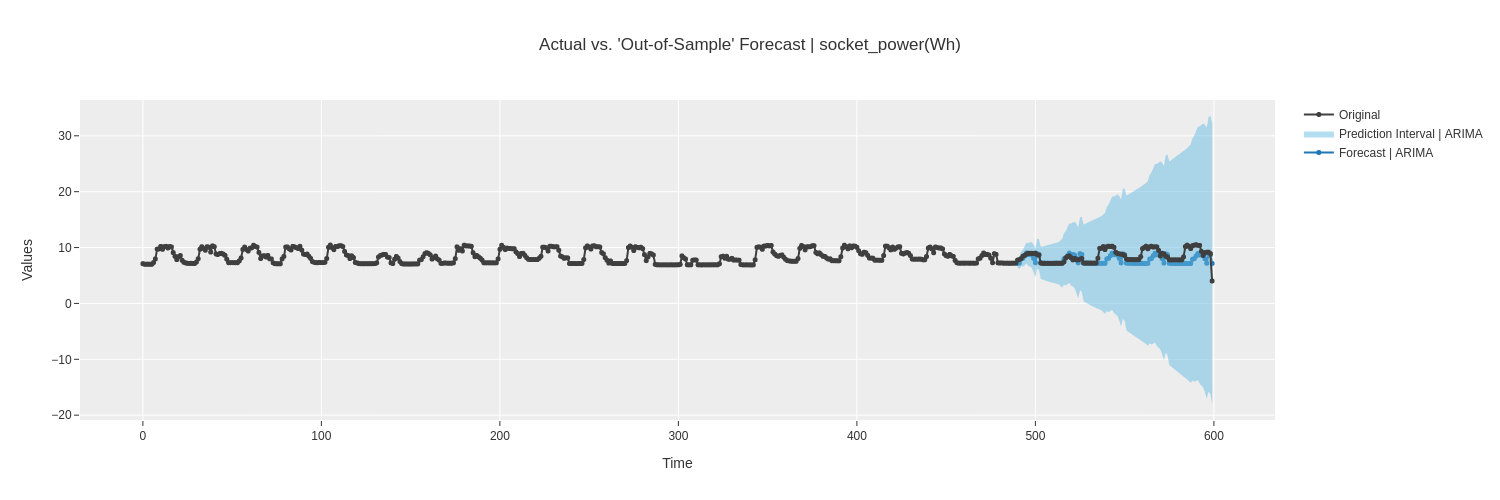

In [48]:
exp_uni.plot_model(
    model,
    fig_kwargs={
        # 'notebook' 으로 설정시 interactive 플롯을 생성합니다.
        "renderer": "png",
        "width": 1500,
        "height": 500,
    },
)